In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator
from bbtoolkit.data.configparser import EvalConfigParser

In [2]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000,)
np.set_printoptions(suppress=False)

In [44]:
from dataclasses import dataclass
from bbtoolkit.data import WritablePickle

@dataclass
class GCMap(WritablePickle):
    """
    Represents a Grid Cells activity Map.

    Attributes:
    -----------
    frequency_rates : np.ndarray
        An array representing the frequency rates.
    standard_deviations : np.ndarray
        An array representing the standard deviations.
    """
    frequency_rates: np.ndarray
    standard_deviations: np.ndarray


class GCGenerator(AbstractGenerator):
    """
    A class for generating grid cell firing rate maps based on specified parameters.
    """
    def __init__(
        self,
        res: float,
        x_max: int,
        y_max: int,
        n_mod: int,
        n_per_mod: int,
        f_mods: np.ndarray,
        fac: np.ndarray,
        r_size: np.ndarray,
        orientations: np.ndarray
    ):
        """
        Initialize the GridCellFRGenerator.

        Args:
            res (float): Resolution of the grid.
            x_max (int): Maximum X coordinate.
            y_max (int): Maximum Y coordinate.
            n_mod (int): Number of grid modules.
            n_per_mod (int): Number of offsets per module.
            f_mods (np.ndarray): Frequencies for different modules.
            fac (np.ndarray): Scaling offset steps to cover the complete rhombus.
            r_size (np.ndarray): Template radius in number of pixels for each module.
            orientations (np.ndarray): Orientations for different modules.
            save_path (str): Path where generated data will be saved.
        """

        self.n_mod = n_mod
        self.n_per_mod = n_per_mod
        self.res = res
        self.x_max = x_max
        self.y_max = y_max

        self.f_mods = f_mods
        self.fac = fac
        self.r_size = r_size
        self.orientations = orientations

    def get_coordinates(self) -> tuple[np.ndarray, tuple[int, int]]:
        """
        Generate coordinates and mesh grids.

        Returns:
            tuple[np.ndarray, tuple[int, int]]: Mesh grid of X and Y coordinates and their shape.
        """
        x = np.arange(0, self.x_max + self.res, self.res)
        y = np.arange(0, self.y_max + self.res, self.res)
        xg, yg = np.meshgrid(x, y)
        # Yg and Xg are flipped because of the way matrices are indexed in matlab
        XY = np.column_stack((yg.ravel(), xg.ravel()))
        return XY, (len(x), len(y))

    def get_orientation_params(self, index: int) -> tuple[float, float, np.ndarray]:
        """
        Get parameters for a specific orientation index.

        Args:
            index (int): Index of the orientation.

        Returns:
            Tuple[float, float, np.ndarray]: Frequency, factor, and rotation matrix.
        """
        f = self.f_mods[index]
        fac = self.fac[index]
        orientation = self.orientations[index]
        r = np.array([[np.cos(orientation), -np.sin(orientation)], [np.sin(orientation), np.cos(orientation)]])
        return f, fac, r

    @staticmethod
    def get_basis_vectors() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the basis vectors for the triangular grid pattern.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Three basis vectors representing triangular directions.
        """
        b0 = np.array([np.cos(0), np.sin(0)])
        b1 = np.array([np.cos(np.pi / 3), np.sin(np.pi / 3)])
        b2 = np.array([np.cos(2 * np.pi / 3), np.sin(2 * np.pi / 3)])
        return b0, b1, b2

    @staticmethod
    def get_offset_vectors(fac: float, f: float, r: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Get offset vectors for the triangular grid pattern.

        Args:
            fac (float): Factor for scaling offset vectors.
            F (float): Frequency parameter.
            R (np.ndarray): Rotation matrix.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Two offset vectors based on the given parameters.
        """
        x_off_base1 = 0
        y_off_base1 = fac * (1 / f)
        x_off_base2 = fac * (1 / f) * np.cos(np.pi / 6)
        y_off_base2 = fac * (1 / f) * np.sin(np.pi / 6)
        off_vec1 = np.dot(r, np.array([x_off_base1, y_off_base1]))
        off_vec2 = np.dot(r, np.array([x_off_base2, y_off_base2]))
        return off_vec1, off_vec2

    @staticmethod
    def get_offset(w: int, j: int, off_vec1: np.ndarray, off_vec2: np.ndarray) -> np.ndarray:
        """
        Calculate the offset vector for the grid cell.

        Args:
            w (int): Row index.
            j (int): Column index.
            off_vec1 (np.ndarray): First offset vector.
            off_vec2 (np.ndarray): Second offset vector.

        Returns:
            np.ndarray: Computed offset vector for the grid cell.
        """
        off = (j) / 10 * off_vec1 + (w) / 10 * off_vec2
        return off

    @staticmethod
    def get_z_values(
        f: float,
        xy: np.ndarray,
        r: np.ndarray,
        offset: np.ndarray,
        b0: np.ndarray,
        b1: np.ndarray,
        b2: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calculate the z values for grid cell positions.

        Args:
            f (float): Frequency parameter.
            xy (np.ndarray): Array of XY coordinates.
            r (np.ndarray): Rotation matrix.
            offset (np.ndarray): Offset vector.
            b0 (np.ndarray): First basis vector.
            b1 (np.ndarray): Second basis vector.
            b2 (np.ndarray): Third basis vector.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Calculated z values for the three basis vectors.
        """
        def calculate_z(r, b, xy, f, offset):
            b_dot_xy_offset = f * xy + np.tile(offset, (xy.shape[0], 1))
            b_dot_r = np.tile(np.dot(r, b), (xy.shape[0], 1))
            return np.sum(b_dot_r * b_dot_xy_offset, axis=1)

        z0 = calculate_z(r, b0, xy, f, offset)
        z1 = calculate_z(r, b1, xy, f, offset)
        z2 = calculate_z(r, b2, xy, f, offset)

        return z0, z1, z2

    @staticmethod
    def get_FR_map(z0: np.ndarray, z1: np.ndarray, z2: np.ndarray, shape: tuple[int, int]) -> np.ndarray:
        """
        Calculate the firing rate map based on the given z values.

        Args:
            z0 (np.ndarray): Z values for basis vector 0.
            z1 (np.ndarray): Z values for basis vector 1.
            z2 (np.ndarray): Z values for basis vector 2.
            shape (Tuple[int, int]): Shape of the firing rate map.

        Returns:
            np.ndarray: Firing rate map with values computed from the z values.
        """
        FRmap = np.cos(z0) + np.cos(z1) + np.cos(z2)
        FRmap = FRmap / np.max(FRmap)
        FRmap[FRmap < 0] = 0
        return np.reshape(FRmap, shape)

    @staticmethod
    def normalize(matrix: np.ndarray) -> np.ndarray:
        """
        Normalize a matrix by dividing all its elements by the maximum value.

        Args:
            matrix (np.ndarray): Matrix to be normalized.

        Returns:
            np.ndarray: Normalized matrix.
        """
        matrix = matrix / np.max(matrix)
        return matrix

    def populate(
        self,
        FRmap: np.ndarray,
        gc_fr_maps: np.ndarray,
        gc_fr_maps_sd: np.ndarray,
        w: int,
        j: int,
        i: int
    ) -> None:
        """
        Populate the grid cell firing rate maps with values computed from the given firing rate map.

        Args:
            FRmap (np.ndarray): Firing rate map to be populated.
            gc_fr_maps (np.ndarray): Grid cell firing rate maps.
            gc_fr_maps_sd (np.ndarray): Standard deviations for grid cell firing rate maps.
            w (int): Row index.
            j (int): Column index.
            i (int): Orientation index.

        Returns:
            None
        """
        shape = FRmap.shape
        tmp = np.zeros((int(shape[0] / 10), int(shape[1] / 10)))
        for k in range(int(shape[0] / 10)):
            for l in range(int(shape[1] / 10)):
                x_low, y_low = k * 10, l * 10
                tmp[k, l] = np.mean(
                    FRmap[
                        # in window of size 10x10 take mean of central 8x8 pixels
                        x_low + 1: x_low + 9,
                        y_low + 1: y_low + 9
                    ]
                )

        gc_fr_maps[:, :, (j) * int(np.sqrt(self.n_per_mod)) + w, i] = FRmap.T
        gc_fr_maps_sd[:, :, (j) * int(np.sqrt(self.n_per_mod)) + w, i] = (tmp / (np.max(tmp) + 1e-7)).T

    def generate(self) -> GCMap:
        """
        Generate grid cell firing rate maps.

        Args:
            save (bool, optional): Whether to save the generated maps. Defaults to False.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Generated firing rate maps and associated maps with standard deviations.
        """
        xy, shape = self.get_coordinates()

        b0, b1, b2 = self.get_basis_vectors()

        gc_fr_maps = np.zeros((*shape, self.n_per_mod, self.n_mod))
        gc_fr_maps_sd = np.zeros((shape[0] // 10, shape[1] // 10, self.n_per_mod, self.n_mod))

        for i in range(len(self.orientations)):
            f, fac, r = self.get_orientation_params(i)
            off_vec1, off_vec2 = self.get_offset_vectors(fac, f, r)

            for w in range(int(np.sqrt(self.n_per_mod))):
                for j in range(int(np.sqrt(self.n_per_mod))):
                    offset = self.get_offset(w, j, off_vec1, off_vec2)
                    z0, z1, z2 = self.get_z_values(f, xy, r, offset, b0, b1, b2)
                    FRmap = self.normalize(self.get_FR_map(z0, z1, z2, shape))

                    self.populate(
                        FRmap,
                        gc_fr_maps,
                        gc_fr_maps_sd,
                        w, j, i
                    )

        return GCMap(gc_fr_maps, gc_fr_maps_sd)


cfg_path = '../cfg/cells/grid_cells.ini'
config = EvalConfigParser()
config.read(cfg_path)

space_config = config['Space']

n_mod = space_config.eval('n_mod')
n_perr_mod = space_config.eval('n_per_mod')
res = space_config.eval('res')
x_max = space_config.eval('x_max')
y_max = space_config.eval('y_max')

neurons_config = config['Neurons']
f_mods = neurons_config.eval('f_mods', locals={'pi': np.pi})
fac = neurons_config.eval('FAC')
r_size = neurons_config.eval('r_size')
orientations = neurons_config.eval('orientations', locals={'pi': np.pi})


generator = GCGenerator(
    res,
    x_max,
    y_max,
    n_mod,
    n_perr_mod,
    f_mods,
    fac,
    r_size,
    orientations
)

gc = generator.generate()

In [72]:
GC_FR_maps.shape

(441, 441, 100, 7)

In [45]:
GC_FR_maps_SD[0, 15:, 0, 0]

array([0.25565141, 0.18229825, 0.11010566, 0.03977881, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ])

In [35]:
GC_FR_maps_SD[0, 15:, 0, 0]

array([0.25565141, 0.18229825, 0.11010566, 0.03977881, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ])

In [46]:
GC_FR_maps[0, 186:, 0, 0]

array([0.02969801, 0.02283934, 0.0160075 , 0.00920313, 0.00242683, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
       0.

In [38]:
GC_FR_maps[0, 186:, 0, 0]

array([0.02969801, 0.02283934, 0.0160075 , 0.00920313, 0.00242683, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
       0.

In [23]:
GC_FR_maps[66:77, :10, 0, 3]

array([[0.01532582, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01520424, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0148396 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01423226, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0133828 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01229204, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01096102, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.009

In [5]:
GC_FR_maps[:10, :10, 0, 1]

array([[0.8719907 , 0.86892842, 0.86572695, 0.86238705, 0.85890947, 0.85529504, 0.85154459, 0.84765899, 0.84363914, 0.83948597],
       [0.87710858, 0.87403764, 0.87082712, 0.86747777, 0.86399036, 0.8603657 , 0.85660464, 0.85270805, 0.84867684, 0.84451193],
       [0.88209528, 0.87901592, 0.87579659, 0.87243805, 0.86894108, 0.86530648, 0.86153511, 0.85762783, 0.85358556, 0.84940923],
       [0.88694965, 0.8838621 , 0.88063422, 0.87726675, 0.87376048, 0.87011623, 0.86633483, 0.86241717, 0.85836415, 0.85417672],
       [0.89167055, 0.88857505, 0.88533886, 0.88196273, 0.87844744, 0.87479381, 0.87100268, 0.86707493, 0.86301149, 0.85881328],
       [0.89625688, 0.89315368, 0.88990944, 0.8865249 , 0.88300086, 0.87933813, 0.87553756, 0.87160004, 0.86752648, 0.86331782],
       [0.90070759, 0.89759692, 0.89434487, 0.89095219, 0.88741967, 0.88374813, 0.87993842, 0.87599143, 0.87190806, 0.86768928],
       [0.90502162, 0.90190373, 0.89864413, 0.89524357, 0.89170284, 0.88802278, 0.88420422, 0.880

In [11]:
GC_FR_maps[:10, :10, 0, 2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
GC_FR_maps[:10, :10, 0, 0]

array([[0.36610313, 0.36813417, 0.37016287, 0.37218924, 0.37421325, 0.37623492, 0.37825423, 0.38027117, 0.38228574, 0.38429794],
       [0.36727686, 0.36930513, 0.37133106, 0.37335466, 0.37537591, 0.37739481, 0.37941134, 0.38142552, 0.38343732, 0.38544674],
       [0.36845144, 0.37047694, 0.37250011, 0.37452094, 0.37653942, 0.37855554, 0.38056931, 0.38258071, 0.38458973, 0.38659638],
       [0.36962688, 0.37164961, 0.37367001, 0.37568807, 0.37770377, 0.37971713, 0.38172812, 0.38373674, 0.38574299, 0.38774686],
       [0.37080317, 0.37282313, 0.37484076, 0.37685604, 0.37886898, 0.38087955, 0.38288777, 0.38489361, 0.38689708, 0.38889817],
       [0.37198031, 0.3739975 , 0.37601235, 0.37802486, 0.38003502, 0.38204282, 0.38404825, 0.38605132, 0.38805201, 0.39005032],
       [0.37315829, 0.37517271, 0.37718479, 0.37919452, 0.3812019 , 0.38320692, 0.38520957, 0.38720986, 0.38920776, 0.39120329],
       [0.37433712, 0.37634876, 0.37835806, 0.38036501, 0.38236961, 0.38437185, 0.38637172, 0.388

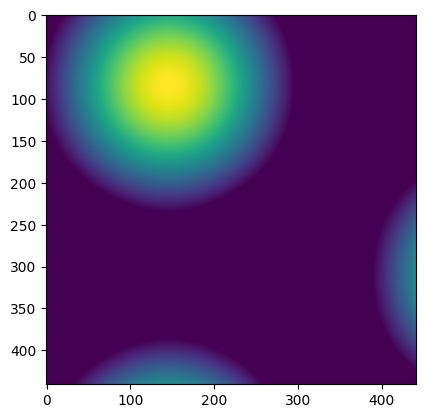

In [2]:
x = np.load('../data/grid_cells/GC_FR_maps_BB.npy')
plt.imshow(x[:, :, 0, 6])

In [ ]:
x.shape

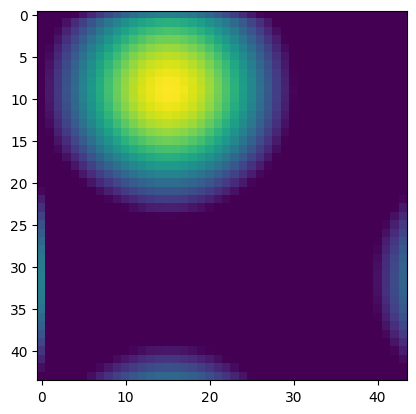

In [3]:
x = np.load('../data/grid_cells/GC_FR_maps_SD.npy')
plt.imshow(x[:, :, 0, 6])

In [26]:
x = np.load('../data/place_cells/GC2PCwts_BB.npy')

In [27]:
x.shape

(1936, 700)

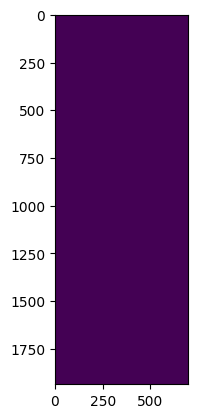

In [28]:
plt.imshow(x)